# Final Visualization

In this notebook, we visualize the results of the clustering performed in the previous step. Using both static (matplotlib/seaborn) and interactive (folium) maps, we provide an intuitive understanding of how Buenos Aires neighborhoods are segmented based on their socio-environmental characteristics.


In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [106]:
df_clustered = pd.read_csv('../data/Full_data_clustered.csv', sep=',')
X_clustered = pd.read_csv('../data/Clean_feature_clustered.csv', sep=',')

In [107]:
cluster_summary = X_clustered.groupby('cluster').mean().round(2)

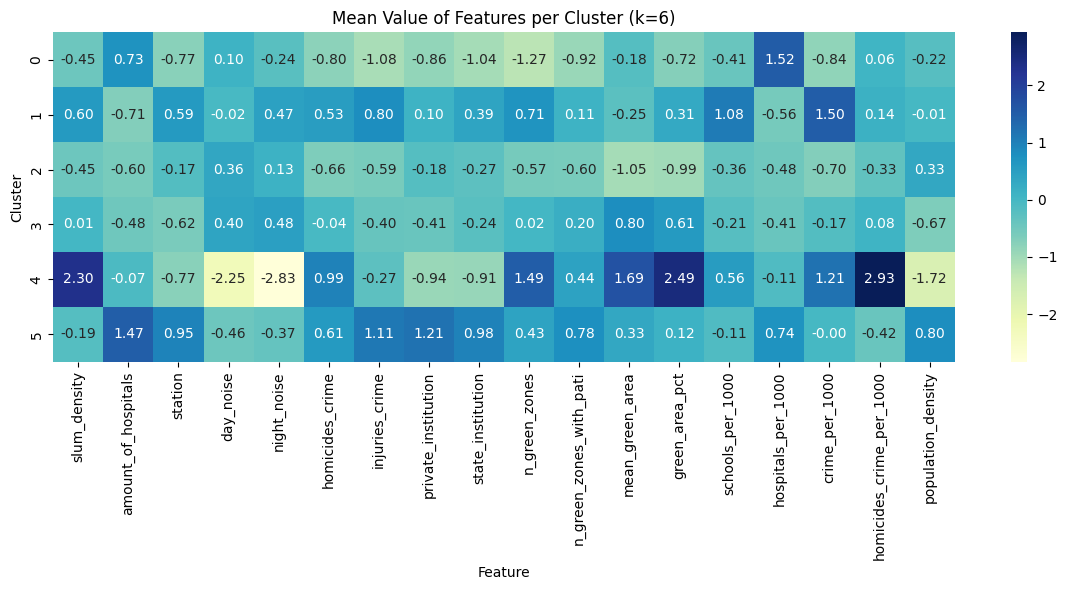

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Mean Value of Features per Cluster (k=6)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

Let's increase the readability of the output

In [109]:
positive_features = [
    'amount_of_hospitals',
    'station',
    'private_institution',
    'state_institution',
    'n_green_zones',
    'n_green_zones_with_pati',
    'mean_green_area',
    'green_area_pct',
    'schools_per_1000',
    'hospitals_per_1000'
]

negative_features = [
    'slum_density',
    'day_noise',
    'night_noise',
    'homicides_crime',
    'injuries_crime',
    'crime_per_1000',
    'homicides_crime_per_1000',
    'population_density'
]

ordered_features = positive_features + negative_features
cluster_summary_ordered = cluster_summary[ordered_features]

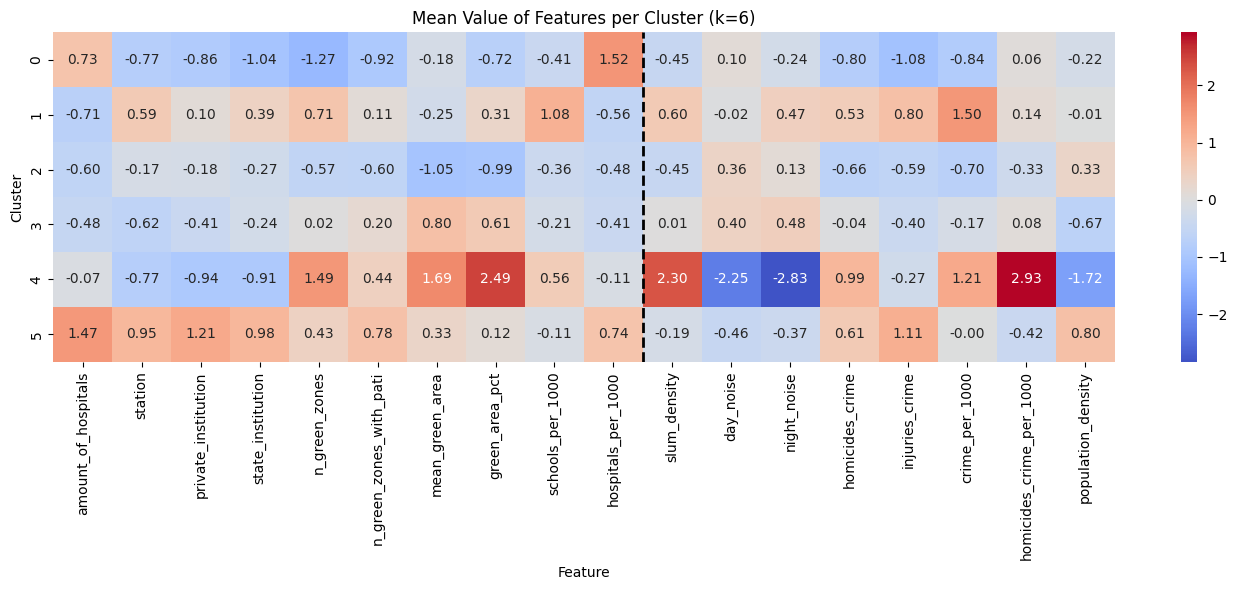

In [110]:
plt.figure(figsize=(14, 6))
sns.heatmap(cluster_summary_ordered, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.axvline(x=len(positive_features), color='black', linestyle='--', lw=2)
plt.title("Mean Value of Features per Cluster (k=6)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

The dotted line separates positive and negative signs.

## Let's start with the visualization on map

In [111]:
import geopandas as gpd
from shapely import wkt

df_clustered['geometry'] = df_clustered['geometry'].apply(wkt.loads)
df_clustered = gpd.GeoDataFrame(df_clustered, geometry='geometry', crs='EPSG:4326')

In [112]:
# Colors in hex codes 
cluster_colors = {
0: '#FF0000', # bright red
1: '#654321', # dark brown
2: '#FFFF00', # yellow
3: '#228B22', # deep green
4: '#ADD8E6', # light blue
5: '#0000FF'  # blue
}

In [113]:
df_clustered['color'] = df_clustered['cluster'].map(cluster_colors)

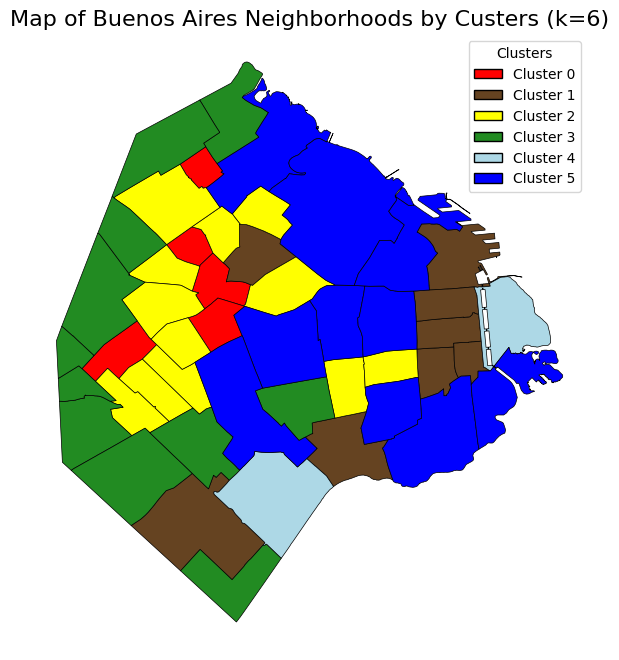

In [114]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=f'Cluster {cluster}')
    for cluster, color in cluster_colors.items()
]

fig, ax = plt.subplots(figsize=(12, 8))

for cluster_id, color in cluster_colors.items():
    df_clustered[df_clustered['cluster'] == cluster_id].plot(
        ax=ax,
        color=color,
        edgecolor='black',
        linewidth=0.5
    )

# Добавим легенду
ax.legend(handles=legend_elements, title='Clusters')
ax.set_title("Map of Buenos Aires Neighborhoods by Custers (k=6)", fontsize=16)
ax.axis('off')
plt.show()

## Individual Feature Visualization by Neighborhood

We use choropleth maps to display the distribution of key features across Buenos Aires neighborhoods. These visualizations help to understand the spatial patterns of the most important indicators used in clustering.


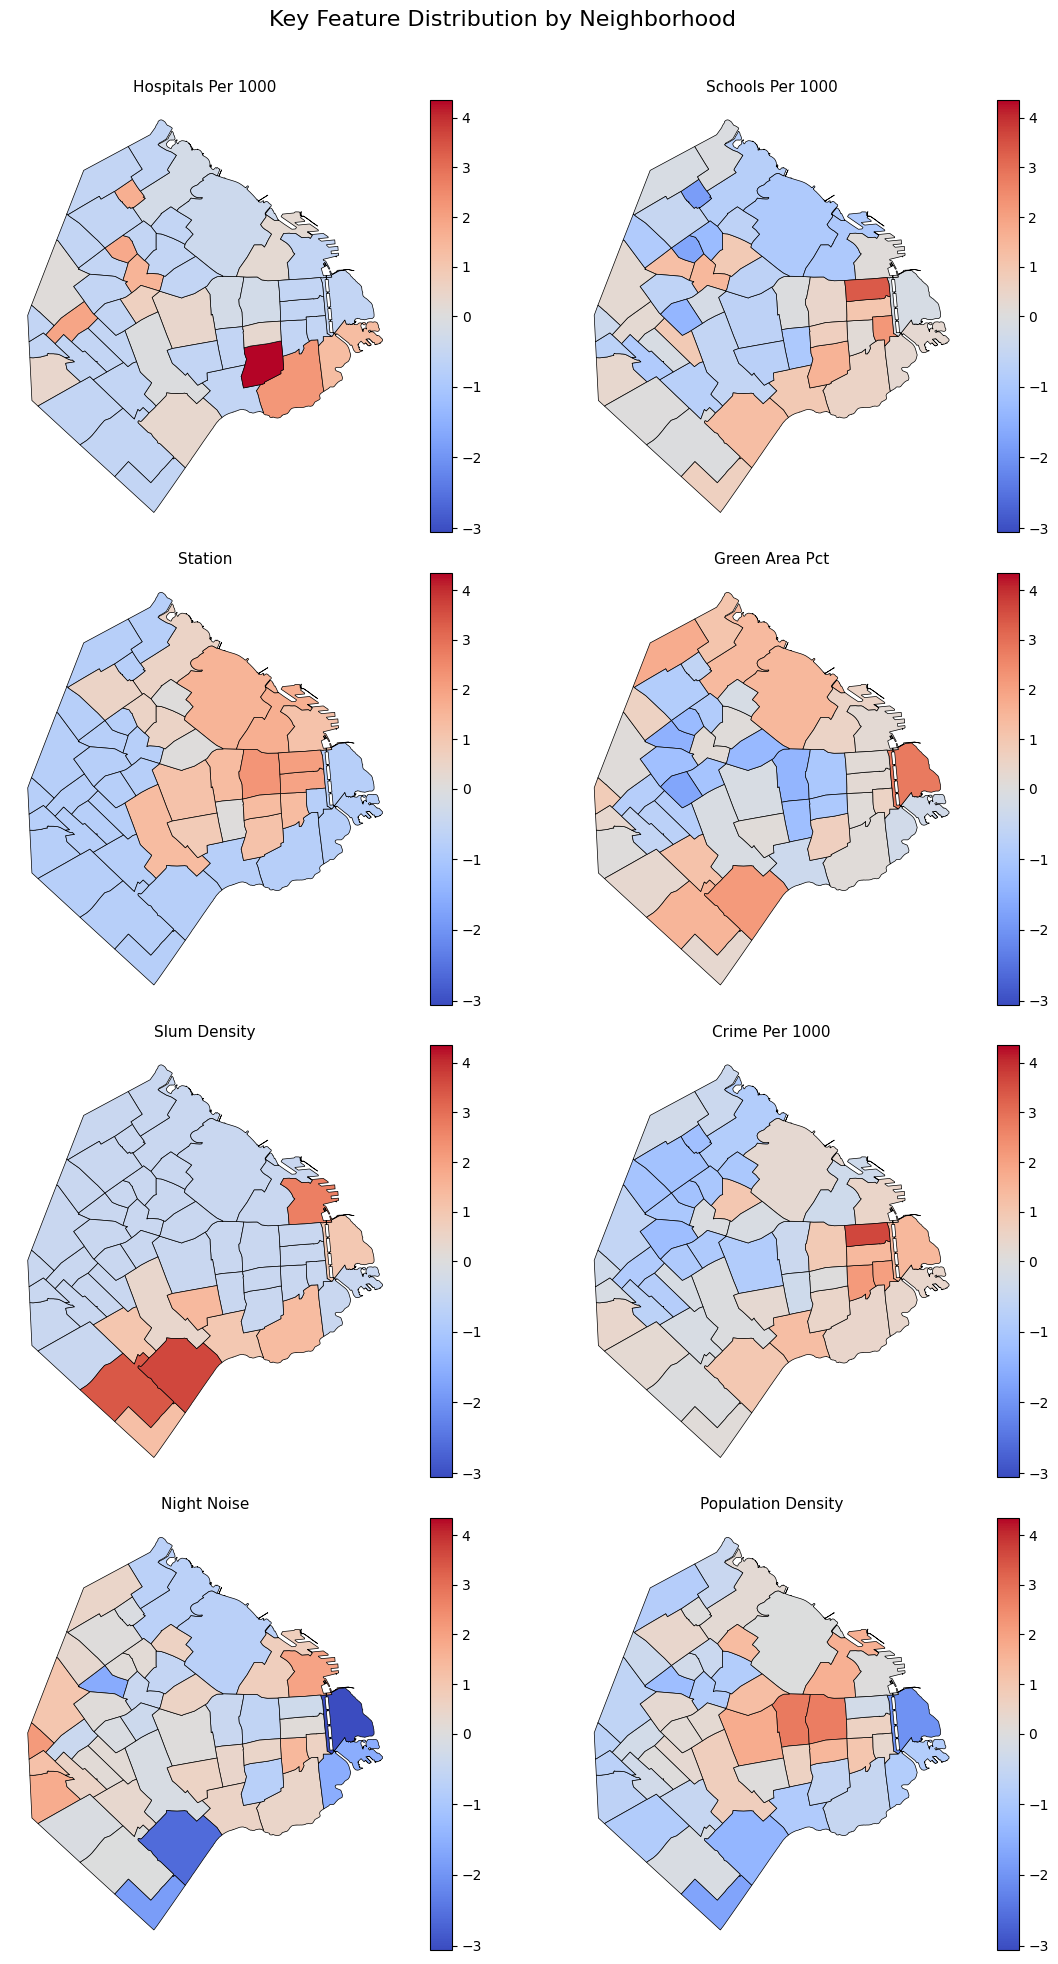

In [86]:
import matplotlib.colors as mcolors
features = [
    'hospitals_per_1000', 'schools_per_1000', 'station', 'green_area_pct', 
    'slum_density', 'crime_per_1000', 'night_noise', 'population_density' 
]

# --- Построение сабграфиков 4x2 ---
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 20))
axes = axes.flatten()

vmin = min(df_clustered[feature].min() for feature in features)
vmax = max(df_clustered[feature].max() for feature in features)
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = 'coolwarm'

for idx, feature in enumerate(features):
    ax = axes[idx]
    df_clustered.plot(column=feature, cmap=cmap, linewidth=0.5, ax=ax,
                      edgecolor='black', legend=True, norm=norm)
    ax.set_title(f"{feature.replace('_', ' ').title()}", fontsize=11)
    ax.axis('off')

# Удалим лишнюю пустую ось
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Key Feature Distribution by Neighborhood", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Let's try to mark up several areas manually

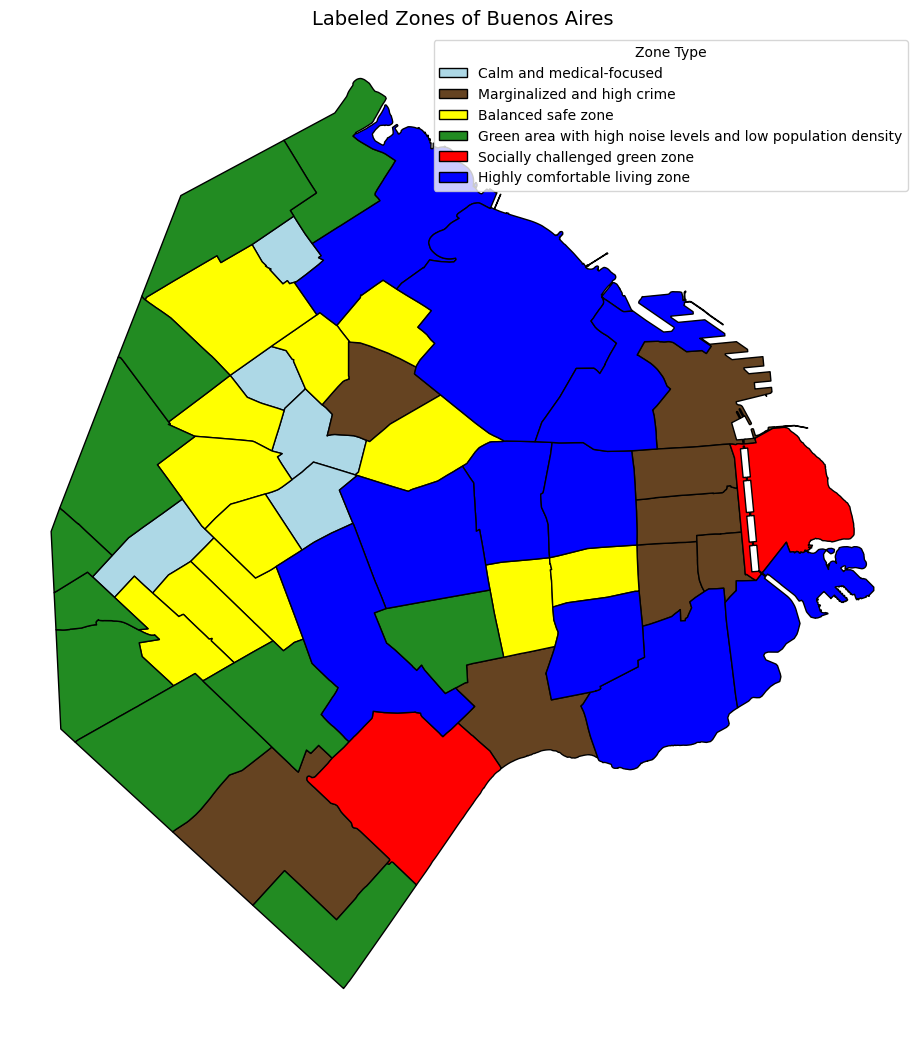

In [83]:
cluster_to_label = {
	0: "Calm and medical-focused",
	1: "Marginalized and high crime",
	2: "Balanced safe zone",
	3: "Green area with high noise levels and low population density",
	4: "Socially challenged green zone",
	5: "Highly comfortable living zone"
}
df_clustered['label'] = df_clustered['cluster'].map(cluster_to_label)

label_colors = {
    "Calm and medical-focused": '#ADD8E6', # light blue
    "Marginalized and high crime": '#654321', # dark brown
    "Balanced safe zone": '#FFFF00', # yellow
    "Green area with high noise levels and low population density": '#228B22', # deep green
    "Socially challenged green zone": '#FF0000', # bright red 
    "Highly comfortable living zone": '#0000FF'  # blue
}
df_clustered['color'] = df_clustered['label'].map(label_colors)

# Визуализация
fig, ax = plt.subplots(figsize=(16, 13))
for label, color in label_colors.items():
    df_clustered[df_clustered['label'] == label].plot(ax=ax, color=color, edgecolor='black')

legend_elements = [Patch(facecolor=color, edgecolor='black', label=label) for label, color in label_colors.items()]
ax.legend(handles=legend_elements, title="Zone Type")
ax.set_title("Labeled Zones of Buenos Aires", fontsize=14)
ax.axis('off')
plt.show()

### Interactive Folium Map

To allow spatial interpretation of our clustering results, we use Folium to build an interactive map of Buenos Aires.  
Each neighborhood polygon is colored by its assigned label and includes a popup with selected indicators.


In [102]:
import folium
import geopandas as gpd
from branca.colormap import linear

# Убедись, что crs = EPSG:4326
df_clustered = df_clustered.to_crs(epsg=4326)

# Создаем карту, центрируем на BA
m = folium.Map(location=[-34.6, -58.45], zoom_start=11, tiles="cartodbpositron")

# Уникальные лейблы и цвета
unique_labels = df_clustered['label'].unique()
label_colors = {
    "Calm and medical-focused": '#ADD8E6', # light blue
    "Marginalized and high crime": '#654321', # dark brown
    "Balanced safe zone": '#FFFF00', # yellow
    "Green area with high noise levels and low population density": '#228B22', # deep green
    "Socially challenged green zone": '#FF0000', # bright red 
    "Highly comfortable living zone": '#0000FF'  # blue
    }

def popup_html(row):
    html = f"""
    <div style="font-family:Arial,sans-serif; font-size:13px; line-height:1.4">
        <b style="font-size:14px">{row['neighborhood'].upper()}</b><br>
        <b>Zone:</b> {row['label']}<br><br>
        <table style="width:100%; font-size:12px;">
          <tr><td><b>Crime per 1000:</b></td><td>{row.get('crime_per_1000', 'n/a')}</td></tr>
          <tr><td><b>Slum density:</b></td><td>{row.get('slum_density', 'n/a')}</td></tr>
          <tr><td><b>Night noise:</b></td><td>{row.get('night_noise', 'n/a')}</td></tr>
          <tr><td><b>Green area %:</b></td><td>{row.get('green_area_pct', 'n/a')}</td></tr>
          <tr><td><b>Hospitals / 1000:</b></td><td>{row.get('hospitals_per_1000', 'n/a')}</td></tr>
          <tr><td><b>Schools / 1000:</b></td><td>{row.get('schools_per_1000', 'n/a')}</td></tr>
        </table>
    </div>
    """
    return html

for _, row in df_clustered.iterrows():
    sim_geo = gpd.GeoSeries([row['geometry']]).simplify(0.001)
    geo_json = sim_geo.to_json()
    color = label_colors.get(row['label'], "#cccccc")

    gj = folium.GeoJson(
        data=geo_json,
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.6
        },
        tooltip=folium.Tooltip(row['neighborhood']),
        popup=folium.Popup(popup_html(row), max_width=300)
    )
    gj.add_to(m)


legend_html = """
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 250px; height: auto; 
     background-color: white; z-index:9999; padding: 10px; border:1px solid #ccc;">
     <b>Zone Types</b><br>
"""
for label, color in label_colors.items():
    legend_html += f'<i style="background:{color};width:20px;height:10px;display:inline-block;"></i> {label}<br>'
legend_html += "</div>"
m.get_root().html.add_child(folium.Element(legend_html))

# Сохраняем
m.save("../docs/buenos_aires_zones_map.html")


## Conclusion

In this notebook, we explored the spatial variation of key features and visualized clustering results through thematic and interactive maps.  
The patterns observed reinforce the effectiveness of unsupervised clustering in highlighting urban disparities and comfort levels across neighborhoods.

This visual layer adds interpretability and can support urban policy decisions, further research, or public-facing dashboards.
